# Multi Layered Perception Neural Network

### Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as du
from torch.utils.data import Dataset
import pandas as pd
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score
from sklearn.linear_model import LogisticRegression
import warnings  
import sklearn.exceptions as skex
warnings.simplefilter("ignore", category = skex.ConvergenceWarning)

### Reading in Dataset

In [2]:
'''
The goal of this project is to create a simple MLP neural network smoke detector. This task can be reduced down to a 
binary classification problem that outputs a binary label where 1 means smoke is detected, and 0 
means no smoke is detected. 
I will be using a smoke detection dataset found here, https://www.kaggle.com/datasets/deepcontractor/smoke-detection-dataset.
This dataset contains 13 features that represents 
''' 
df = pd.read_csv("smoke_detection_iot.csv")
df = df.dropna()
df = df.drop(["Unnamed: 0", "UTC"], axis = 1)
df.head()

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0,0
1,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,1,0
2,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,2,0
3,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,3,0
4,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,4,0


### Converting dataframe to numpy arrays

In [3]:
df = df.sample(frac=1)
data = df.values.astype("float32")
train_data = data[:int(data.shape[0] * .8)]
valid_data = data[int(data.shape[0] * .8):int(data.shape[0] * .9)]
test_data = data[int(data.shape[0] * .9):]
print(f"shape of train data: {train_data.shape}")
print(f"shape of validation data: {valid_data.shape}")
print(f"shape of test data: {test_data.shape}")

shape of train data: (50104, 14)
shape of validation data: (6263, 14)
shape of test data: (6263, 14)


### Building Dataset class

In [4]:
class smoke_detection_data(Dataset):
    def __init__(self, data):
        super(smoke_detection_data, self).__init__()
        self.data = data

    def __len__(self):
        '''return len of dataset'''
        return self.data.shape[0]
    def __getitem__(self, idx):
        '''return data, label'''
        return self.data[idx,:-1], self.data[idx,-1]

### Define MLP model

In [5]:
class MLP(nn.Module):
    '''
    code for using pytorch was taken from Prof Zaki's Machine Learning
    in BioInformatics class. I did not need outside resources other than 
    his starter boilerplate code and the code I wrote for his class. 
    '''
    def __init__(self, in_dim, hidden_dim, out_dim, num_layers=2, dropout=.5):
        '''
           in_dim: input layer dim
           hidden_dim: hidden layer dim
           out_dim: output layer dim
           num_layers: number of linear layers
           dropout: percent to dropout for each dropout layer
        '''
        
        super(MLP, self).__init__()
        assert(num_layers >= 2)  # model cant have less than 2 layers
        self.in_layer = nn.Linear(in_dim, hidden_dim)
        self.layers = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for i in range(num_layers-2)]) 
        self.dropouts = nn.ModuleList([nn.Dropout(p=dropout) for i in range(num_layers-2)])
        self.out_layer = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        '''
        ReLU activation will be applied to all layers except last layer. No activation function will be applied to 
        last layer since BCE loss function applies sigmoid. Dropout layers will be applied to all layers except first
        and layer linear layer
        '''
        x = F.relu(self.in_layer(x))
        for l, d in zip(self.layers, self.dropouts): 
            x = d(F.relu(l(x))) 
        x = self.out_layer(x)  
        return x

### Set up training

In [6]:
# model will be trained on gpu if it is available, otherwise training will be done on cpu
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'  
print(f"using device: {device}")

# hyper parameters
batch_size = 512
learning_rate = 0.001
max_epochs = 1000 # early stopping will prevent training from every reaching max_epochs
in_dim = 13
hidden_dim = 7
output_dim = 1
num_layers = 7
dropout = .1

# initializing model and optimizer
model = MLP(in_dim, hidden_dim, output_dim, num_layers, dropout)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# load dataset into a dataloader to send out data in batches
train_loader = du.DataLoader(dataset=smoke_detection_data(train_data),
                             batch_size=batch_size,
                             shuffle=True)
valid_loader = du.DataLoader(dataset=smoke_detection_data(valid_data),
                             batch_size=batch_size,
                             shuffle=True)
test_loader = du.DataLoader(dataset=smoke_detection_data(test_data),
                             batch_size=batch_size,
                             shuffle=True)
# send model over to device
model = model.to(device)
model.train()

using device: cuda:0


MLP(
  (in_layer): Linear(in_features=13, out_features=7, bias=True)
  (layers): ModuleList(
    (0): Linear(in_features=7, out_features=7, bias=True)
    (1): Linear(in_features=7, out_features=7, bias=True)
    (2): Linear(in_features=7, out_features=7, bias=True)
    (3): Linear(in_features=7, out_features=7, bias=True)
    (4): Linear(in_features=7, out_features=7, bias=True)
  )
  (dropouts): ModuleList(
    (0): Dropout(p=0.1, inplace=False)
    (1): Dropout(p=0.1, inplace=False)
    (2): Dropout(p=0.1, inplace=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Dropout(p=0.1, inplace=False)
  )
  (out_layer): Linear(in_features=7, out_features=1, bias=True)
)

### Training loop + Validation step

In [7]:
last_loss = np.inf
train_loss_list = []
valid_loss_list = []
valid_acc_list = []
recall_list = []
epoch_list = []
# iterating through all epochs
for epoch in range(1, max_epochs + 1):    
    epoch_list.append(epoch)
    # training step
    train_loss = 0.
    model.train()
    # iterating through entire dataset in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # sending batch over to device
        data, target = data.to(device), target.to(device)
        # zeroing out previous gradients
        optimizer.zero_grad()
        # getting predictions from model
        pred = model(data)[:,0]
        # calculating BCE loss between predictions and labels
        loss = F.binary_cross_entropy_with_logits(pred, target)
        train_loss += loss.item()
        # calculating backprop and using an adam optimizer for update step 
        loss.backward()
        optimizer.step()
    
    # validation step
    valid_loss = 0
    valid_acc = 0
    epoch_recall_list = []
    # turning off grad and dropout layers for evaluation step
    model.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(valid_loader):
            data, target = data.to(device), target.to(device)
            pred = model(data)[:,0]
            loss = F.binary_cross_entropy_with_logits(pred, target)
            valid_loss += loss.item()
            # applying sigmoid activation to predictions to squash them between 0 and 1
            pred = torch.sigmoid(pred)
            # rounding predictions to convert probabilities to binary labels
            pred = torch.round(pred)
            # calcualting accuracy
            valid_acc += torch.sum(pred == target).float()
            epoch_recall_list.append(recall_score(target.tolist(), pred.tolist()))
            
    # calculating average loss, accuracy, and recall score 
    train_loss /= len(train_loader.dataset)
    valid_loss /= len(valid_loader.dataset)
    valid_acc /= len(valid_loader.dataset) 
    recall = sum(epoch_recall_list) / len(epoch_recall_list)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    recall_list.append(recall)
    valid_acc_list.append(valid_acc.to("cpu"))

    # printing loss, accuracy, and recall per epoch
    print(f'Epoch: {epoch}, Loss: {train_loss:.6f}, Validation Loss: {valid_loss:.6f}, Validation Accuracy : {valid_acc:.6f}, Valication Recall Score: {recall:.6f}')
    # if previous loss is less than current loss, end training (Early Stopping)
    if(valid_loss <= last_loss):
        last_loss = valid_loss
    else:
        break

Epoch: 1, Loss: 0.001636, Validation Loss: 0.001229, Validation Accuracy : 0.725052, Valication Recall Score: 0.999780
Epoch: 2, Loss: 0.001182, Validation Loss: 0.001150, Validation Accuracy : 0.727607, Valication Recall Score: 0.999789
Epoch: 3, Loss: 0.001076, Validation Loss: 0.000985, Validation Accuracy : 0.732237, Valication Recall Score: 0.999794
Epoch: 4, Loss: 0.000949, Validation Loss: 0.000768, Validation Accuracy : 0.734153, Valication Recall Score: 0.999370
Epoch: 5, Loss: 0.000812, Validation Loss: 0.000627, Validation Accuracy : 0.736867, Valication Recall Score: 0.999348
Epoch: 6, Loss: 0.000688, Validation Loss: 0.000529, Validation Accuracy : 0.838256, Valication Recall Score: 0.998544
Epoch: 7, Loss: 0.000594, Validation Loss: 0.000465, Validation Accuracy : 0.951780, Valication Recall Score: 0.947990
Epoch: 8, Loss: 0.000479, Validation Loss: 0.000310, Validation Accuracy : 0.939805, Valication Recall Score: 0.922316
Epoch: 9, Loss: 0.000315, Validation Loss: 0.000

### Plotting loss

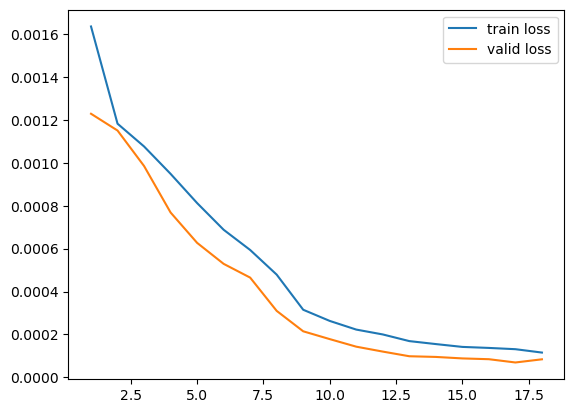

In [8]:
plt.plot(epoch_list, train_loss_list, label="train loss")
plt.plot(epoch_list, valid_loss_list, label="valid loss")
plt.legend()

### Plotting Accruacy and Recall per epoch

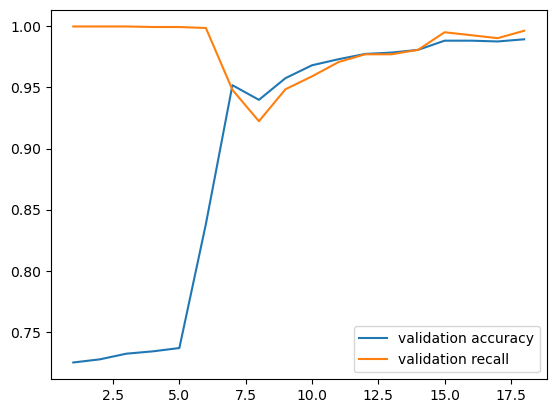

In [9]:
plt.plot(epoch_list, valid_acc_list, label="validation accuracy")
plt.plot(epoch_list, recall_list, label="validation recall")
plt.legend()

### Testing model on new data

In [10]:
# testing model on test dataset
test_loss = 0
test_acc = 0
recall_list = []
model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        pred = model(data)[:,0]
        loss = F.binary_cross_entropy_with_logits(pred, target)
        test_loss += loss.item()
        pred = torch.sigmoid(pred)
        pred = torch.round(pred)
        test_acc += torch.sum(pred == target).float()
        recall_list.append(recall_score(target.cpu(), pred.cpu()))
# average loss per example
test_loss /= len(test_loader.dataset)
test_acc /= len(test_loader.dataset) 
recall = sum(recall_list) / len(recall_list)
print(f'Test Loss: {test_loss:.6f}, Test Accuracy: {test_acc:.6f}, Test Recall Score: {recall:.6f}')

Test Loss: 0.000083, Test Accuracy: 0.988344, Test Recall Score: 0.997662


## Task 3
I chose my hyperparameters using a binary search strategy where I 
would choose two relative extremes for each parameter and train 
the model on the parmeters to see how fast the model converged, 
how stable the training was, and how prone to overfitting it was.
For instance, I found that a learning rate of 0.01 would caught the model
to suffer from exploding gradient, which a learning rate of 0.000001 would 
cause the model to not learn at all. For regularization, I used early stopping 
and dropout layers because training for the mlp was unstable and extremly prone to 
overfit. By using early stopping and dropout layers in almost every linear layer of the 
model, I significantly improved the stability of the training loop. After using the 
adam optimizer, I found that the model converged faster and was training was more stabalized
when compared to before.




## Task 4

## Baseline Model: Logistic Regression

### Training baseline model

In [11]:
acc_list = []
recall_list = []
max_iter_list = []
for i in range(1,50):
    lr_model = LogisticRegression(random_state=0, max_iter=i)
    clf = lr_model.fit(train_data[:,:-1], train_data[:,-1])
    pred = clf.predict(valid_data[:,:-1])
    print(f"Validation Accuracy: {np.sum(pred == valid_data[:,-1]) / pred.shape[0]:.6f}, Recall Score: {recall_score(valid_data[:,-1], pred)}")
    max_iter_list.append(i)
    acc_list.append(np.sum(pred == valid_data[:,-1]) / pred.shape[0])
    recall_list.append(recall_score(valid_data[:,-1], pred))

Validation Accuracy: 0.714514, Recall Score: 1.0
Validation Accuracy: 0.735271, Recall Score: 0.9957541899441341
Validation Accuracy: 0.923200, Recall Score: 0.9036871508379888
Validation Accuracy: 0.919208, Recall Score: 0.895195530726257
Validation Accuracy: 0.929586, Recall Score: 0.9121787709497207
Validation Accuracy: 0.936931, Recall Score: 0.9284916201117318
Validation Accuracy: 0.944276, Recall Score: 0.9396648044692737
Validation Accuracy: 0.950184, Recall Score: 0.9481564245810056
Validation Accuracy: 0.952898, Recall Score: 0.9524022346368715
Validation Accuracy: 0.953537, Recall Score: 0.9557541899441341
Validation Accuracy: 0.955772, Recall Score: 0.9597765363128492
Validation Accuracy: 0.956570, Recall Score: 0.9570949720670391
Validation Accuracy: 0.955932, Recall Score: 0.9593296089385475
Validation Accuracy: 0.956890, Recall Score: 0.9608938547486033
Validation Accuracy: 0.958965, Recall Score: 0.9637988826815642
Validation Accuracy: 0.960722, Recall Score: 0.966480446

### Plotting Baseline model accuracy and recall score

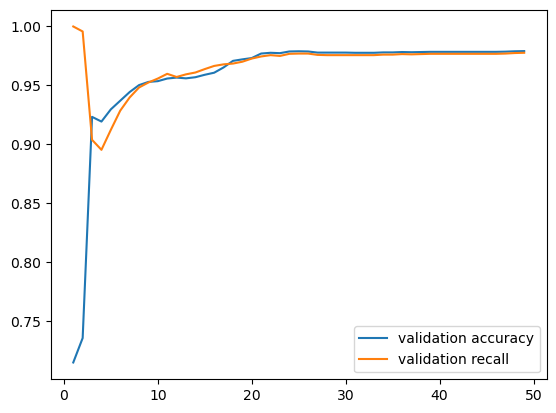

In [12]:
plt.plot(max_iter_list, acc_list, label="validation accuracy")
plt.plot(max_iter_list, recall_list, label="validation recall")
plt.legend()

In [13]:
pred = clf.predict(test_data[:,:-1])
print(f"Test Accuracy: {np.sum(pred == test_data[:,-1]) / pred.shape[0]:.6f}, Recall Score: {recall_score(test_data[:,-1], pred)}")

Test Accuracy: 0.976050, Recall Score: 0.9758551307847082


### Task 4 Writeup
When comparing the MLP model compared to logistic regression, the performance is very similar
as both models have an accuracy and recall score of roughly 98%. If I were to pick between 
the two models, I would choose logistric regression because it had more stable training 
compared to the MLP, which required optimization functions, and several regularization techniques 
in order to prevent overfitting and gradient explosion/diminishing problems. In addition, I 
had to play around with the hyperparameters of the MLP more in order for it to train well.
Part of the reason why the MLP was so hard to train is because the labels for the dataset 
are not balanced. The split between the labels are 1:4, so I had issues in the begining
where the MLP would only predict 0 and still achieve an accuracy of 75%.  